In [22]:
!pip3 install -q --upgrade pip
!pip3 install -q pandas matplotlib seaborn openpyxl climateserv requests netCDF4 folium

In [6]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import climateserv.api
import netCDF4 as nc

In [15]:
def create_precipitation_dataframe(times, longitudes, latitudes, precipitation_data):
    """
    Creates a Pandas DataFrame from the precipitation data with time, longitude, and latitude.

    Parameters:
    times (np.ndarray): The array of times.
    longitudes (np.ndarray): The array of longitudes.
    latitudes (np.ndarray): The array of latitudes.
    precipitation_data (np.ndarray): The 3D array of precipitation data.

    Returns:
    pd.DataFrame: The resulting Pandas DataFrame.
    """

    # We will create a list of dictionaries that will then be converted to a DataFrame
    records = []
    
    # Flatten the 3D precipitation array into a 2D array where each row is a day
    flattened_precipitation = precipitation_data.reshape(-1, longitudes.size * latitudes.size)
    
    # Iterate over each time, longitude, and latitude to create the records
    for time_idx, time in enumerate(times):
        for lon_idx, lon in enumerate(longitudes):
            for lat_idx, lat in enumerate(latitudes):
                # Calculate the index in the flattened array
                flat_index = lon_idx * latitudes.size + lat_idx
                # Create a record for each time, lon, and lat
                records.append({
                    'time': time,
                    'longitude': lon,
                    'latitude': lat,
                    'precipitation': flattened_precipitation[time_idx, flat_index]
                })

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame.from_records(records)
    
    # Convert the 'time' from days since 1970-01-01 to a datetime object
    df['time'] = pd.to_datetime(df['time'], unit='D', origin=pd.Timestamp('1970-01-01'))
    
    return df

def read_nc4_to_dataframe(file_path: str):
    """
    Reads a .nc4 file and converts the precipitation data into a Pandas DataFrame.

    Parameters:
    file_path (str): The path to the .nc4 file.

    Returns:
    pd.DataFrame: The resulting Pandas DataFrame with time, longitude, latitude, and precipitation.
    """
    # Open the .nc4 file
    dataset = nc.Dataset(file_path, 'r')
    
    # Extract data
    times = dataset.variables['time'][:]
    longitudes = dataset.variables['lon'][:]
    latitudes = dataset.variables['lat'][:]
    precipitation_data = dataset.variables['precipitationCal'][:]

    # Close the dataset
    dataset.close()

    # Create a DataFrame
    df = create_precipitation_dataframe(
        times=times, 
        longitudes=longitudes, 
        latitudes=latitudes, 
        precipitation_data=precipitation_data
    )
    
    return df

# Path to the 'gambia' folder
folder_path = 'gambia'

# Initialize a list to store DataFrames
dfs = []

# Iterate over each file in the gambia directory
for filename in os.listdir(folder_path):
    if filename.endswith('.nc4'):  # Check if the file is a .nc4 file
        file_path = os.path.join(folder_path, filename)
        # Read the file to a dataframe and append it to the list
        dfs.append(read_nc4_to_dataframe(file_path=file_path))

# Concatenate all the DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

# Optionally, save the combined dataframe to a CSV file
combined_df.to_csv('combined_precipitation_data.csv', index=False)


        time  longitude   latitude  precipitation
0 2021-04-09 -17.349995  12.950002            0.0
1 2021-04-09 -17.349995  13.050000            0.0
2 2021-04-09 -17.349995  13.149999            0.0
3 2021-04-09 -17.349995  13.250005            0.0
4 2021-04-09 -17.349995  13.350003            0.0


In [16]:
combined_df

,time,longitude,latitude,precipitation
0,2021-04-09,-17.349995,12.950002,0.000000
1,2021-04-09,-17.349995,13.050000,0.000000
2,2021-04-09,-17.349995,13.149999,0.000000
3,2021-04-09,-17.349995,13.250005,0.000000
4,2021-04-09,-17.349995,13.350003,0.000000
...,...,...,...,...
715567,2022-06-17,-13.549991,13.649999,0.078404
715568,2022-06-17,-13.549991,13.750005,0.025344
715569,2022-06-17,-13.549991,13.850003,0.000000
715570,2022-06-17,-13.549991,13.950002,0.000000


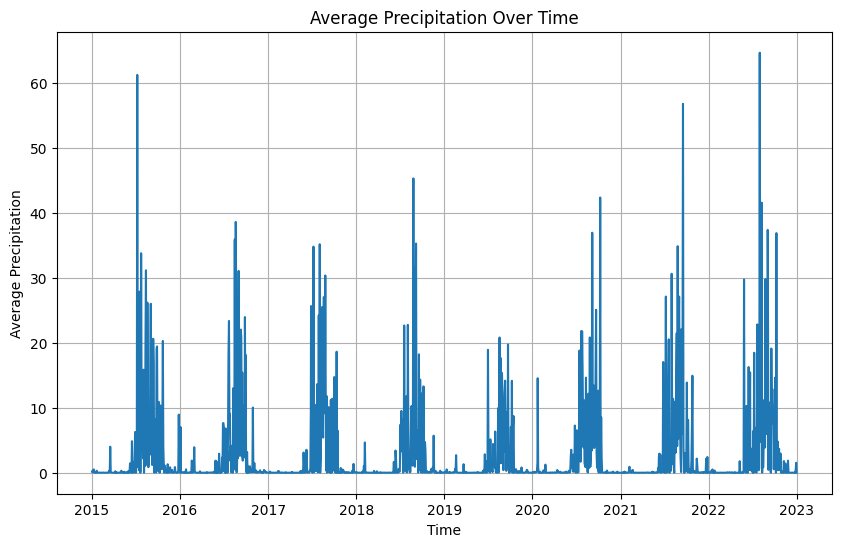

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming combined_df is your DataFrame
# First, ensure that 'time' is in datetime format
combined_df['time'] = pd.to_datetime(combined_df['time'])

# Group by 'time' and calculate the mean of 'precipitation'
average_precipitation = combined_df.groupby('time')['precipitation'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_precipitation, x='time', y='precipitation')
plt.title('Average Precipitation Over Time')
plt.xlabel('Time')
plt.ylabel('Average Precipitation')
plt.grid(True)
plt.show()
